# Direct Optimization of initial weights via Linear Programming

For a fully connected feed forward neural net using RELU activation functions $f$, for a given input $x \in D$ and parameter set $P = (W_1, W_2, ...)$ where each $W_i$ is the weight matrix for a layer of the network, then there exists matrix $A$ such that $f(x, P) = Ax$.

Consider the following generalization loss function, defined as:

$L_{gen} = (f(x, P) - f(x, P^*)) - (f(x^*, P) - f(x^*, P^*))$

where $x^* = x + x'$ and $P^* = P + P'$ for some small perturbations $x', P'$ (applying a different perturbation to each weight matrix in $P'$)

Then if perturbations $x', P'$ do not change the activation pattern of $f(x, P)$, $L_{gen}$ is equivalent to:

$L_{gen} = Ax - (A + A')x - A(x+x') + (A+A')(x+x')$

$ = Ax - Ax - A'x - Ax -Ax' + Ax + Ax' + A'x + A'x'$

$ = A'x'$

Therefore, we can obtain a small value of $L_{gen}$ by finding an initialization $P$ which has few activation patterns for the training data. Since the activation function is RELU, this is equivalent to reducing the amount of times RELU sets an element to 0.

In [1]:
""" First goal: investigate the claim that having fewer RELU 0s is a good thing for an initialization

    - Create a custom RELU subclass using PyTorch to count how often RELU 0s happen for initializations of a MLP
    - Create many different initializations of a model and count the intial RELU 0s
    - Train them all and compare trained model performance vs RELU 0 count

    Ideally, will see a strongly negative correlation between number of RELU 0s and model performance
"""
import math
import time

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import spearmanr
from scipy.optimize import linprog

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.datasets import MNIST

In [2]:
class ReluCount(nn.ReLU):
    """
        Intended to behave identically to nn.ReLU, except for the zero counting.
        To disable zero counting, set count_zeros to False.
    """
    def __init__(self, inplace: bool = False):
        super().__init__(inplace)
        self.zero_count = 0
        self.count_zeros = False

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        true_result = F.relu(input, inplace=self.inplace)
        if self.count_zeros == True:
            for entry in torch.flatten(true_result):
                if entry.item() == 0:
                    self.zero_count += 1
        return true_result


In [3]:
MNIST_MEAN = 0.1307
MNIST_STD = 0.3081

batch_size_train = 64
batch_size_test = 1000


train_loader = DataLoader(MNIST('images/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
                               ])),
                          batch_size=batch_size_train, shuffle=True, pin_memory=False)

test_loader = DataLoader(MNIST('images/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
                               ])),
                         batch_size=batch_size_test, shuffle=True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

flat = torch.flatten(example_data, 1)
flat.shape

torch.Size([1000, 784])

In [5]:
class MnistReluCount(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu_count = ReluCount()
        # mnist images are 1x28x28, so flattened they will have a length of 28*28=784
        self.fc1 = nn.Linear(784, 750)
        self.fc2 = nn.Linear(750, 320)
        self.fc3 = nn.Linear(320, 50)
        self.fc4 = nn.Linear(50, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten batches 2D images to 1D vectors
        x = self.relu_count(self.fc1(x))
        x = self.relu_count(self.fc2(x))
        x = self.relu_count(self.fc3(x))
        x = self.relu_count(self.fc4(x))
        return x

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    total_loss = 0
    batches = 0
    
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        batches += 1
        
    return total_loss / batches

def count_relu_0s(dataloader, model: ReluCount):
    model.eval()
    model.relu_count.count_zeros = True
    for (X, y) in dataloader:
        model(X)
    model.relu_count.count_zeros = False
    return model.relu_count.zero_count

def test_loop(dataloader, model, loss_fn, quiet=False):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    correct = 0
    
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for (X, y) in dataloader:
            out = model(X)
            test_loss += loss_fn(out, y).item()
            pred = out.data.max(1, keepdim=True)[1]
            correct += pred.eq(y.data.view_as(pred)).sum().item()

    test_loss /= num_batches
    accuracy = 100.0 * correct / len(dataloader.dataset)
    if not quiet:
        print(f"Avg loss: {test_loss:>8f}")
        print(f"Accuracy: {correct}/{len(dataloader.dataset)} = {accuracy}")
        print()
    return test_loss, accuracy

In [7]:
lr = .01
epochs = 5
model = MnistReluCount()

In [8]:
# get RELU 0 count
start_t = time.time()
#model_zeros = count_relu_0s(test_loader, model)
print(f"Counting initial ReLU 0s took {time.time() - start_t} seconds")
print(model_zeros)

Counting initial ReLU 0s took 29.118701696395874 seconds
5629986


In [9]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss()

In [10]:
# train model
train_losses = []
test_losses = []


start_t = time.time()
for t in range(epochs):
    
    #train_losses.append(train_loop(train_loader, model, loss_function, optimizer))
    if True:
        print(f"Epoch: {t+1}")
        #test_losses.append(test_loop(test_loader, model, loss_function))
end_t = time.time()
print(f"Finished after {end_t - start_t} seconds")

Epoch: 1
Avg loss: 1.031832
Accuracy: 6409/10000 = 64.09

Epoch: 2
Avg loss: 0.586346
Accuracy: 8033/10000 = 80.33

Epoch: 3
Avg loss: 0.497305
Accuracy: 8208/10000 = 82.08

Epoch: 4
Avg loss: 0.205763
Accuracy: 9392/10000 = 93.92

Epoch: 5
Avg loss: 0.168889
Accuracy: 9486/10000 = 94.86

Finished after 54.39211702346802 seconds


In [42]:
relu_after = count_relu_0s(test_loader, model)
print(relu_after)

9634087


In [7]:
def train_many(train_loader, test_loader, N=100, lr=.01, epochs=5):

    zero_counts = []
    final_accuracies = []

    for _ in range(N):
        model = MnistReluCount()
        model_zeros = count_relu_0s(test_loader, model)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        loss_function = nn.CrossEntropyLoss()
        # do this N many times
        for t in range(epochs):
            train_loop(train_loader, model, loss_function, optimizer)
            
            _, acc = test_loop(test_loader, model, loss_function, quiet=True)

        zero_counts.append(model_zeros)
        final_accuracies.append(acc)
    return zero_counts, final_accuracies

In [8]:
def write_to_file(arr, file_name:str):
    with open(file_name, 'w') as f:
        f.writelines([str(x) +"," for x in arr])

In [9]:
#zeros, accuracies = train_many(train_loader, test_loader, N=200, lr=.01, epochs=5)
#write_to_file(zeros, "zero_counts.csv")
#write_to_file(accuracies, "accuracies.csv")

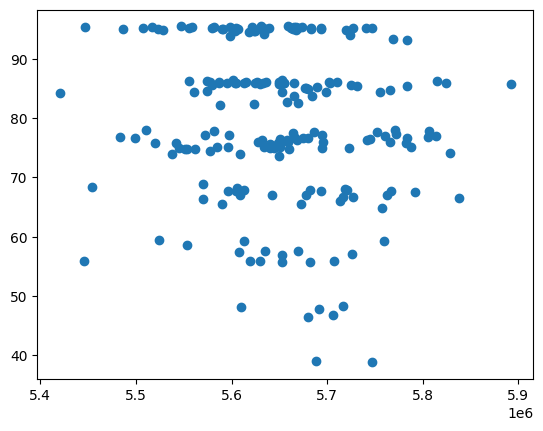

In [49]:
plt.scatter(zeros, accuracies)

In [50]:
np.corrcoef(zeros, accuracies)

array([[ 1.        , -0.12133329],
       [-0.12133329,  1.        ]])

In [51]:
spearmanr(zeros, accuracies)

SignificanceResult(statistic=-0.14086941978090825, pvalue=0.04663062056664219)

In [10]:
def read_my_csv(file_name:str):
    with open(file_name, 'r') as f:
        content = f.read()
        lst = content.strip().split(',')
        return [float(x) for x in lst]

In [2]:
zeros = read_my_csv("zero_counts.csv")
accuracies = read_my_csv("accuracies.csv")

In [5]:
print(zeros[:10])

[5561379.0, 5719543.0, 5636268.0, 5652370.0, 5720403.0, 5673362.0, 5805390.0, 5630034.0, 5727145.0, 5630606.0]


In [12]:
def get_avg_MNIST(sample_size:int=1000):
    loader = DataLoader(MNIST('images/', train=True, download=True,
                                   transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
                                   ])),
                              batch_size=1, shuffle=True, pin_memory=False)
    avg = None
    for sample_num, (X, y) in enumerate(loader):
        if avg is None:
            avg = X
        else:
            avg = avg + X
        if sample_num == sample_size:
            break
    return avg / sample_num


def make_double_I(n):
    I = torch.eye(n)
    I_minus = torch.eye(n) * -1
    #c = torch.ones(n).expand((1, 784))
    #d = torch.ones(n).expand((1, 784)) * -1
    return torch.cat((I, I_minus))


def linprog_parameter(c, in_size, out_size):

    A_eq = torch.ones_like(c).expand((1, in_size)).detach().numpy()
    b_eq = torch.zeros((1,)).detach().numpy()
    c_np = c.detach().numpy()
    result = linprog(c_np, A_eq=A_eq, b_eq=b_eq, bounds=(-(1 / math.sqrt(.2*in_size)), (1 / math.sqrt(.2*in_size))))
    
    result_matrix = torch.stack(
        [torch.from_numpy(result.x.copy()) for _ in range(out_size)]
    )
    
    return torch.nn.Parameter(result_matrix.to(dtype=torch.float32))
    

In [13]:
def sanity_parameter(in_size, out_size):

    result_matrix = torch.FloatTensor(out_size, in_size).uniform_(-1 / math.sqrt(in_size), 1 / math.sqrt(in_size))
    return torch.nn.Parameter(result_matrix.to(dtype=torch.float32))

def sanity_replacement():
    model = MnistReluCount()
    model.fc1.weight = sanity_parameter(784, 750)
    model.fc2.weight = sanity_parameter(750, 320)
    model.fc3.weight = sanity_parameter(320, 50)
    model.fc4.weight = sanity_parameter(50, 10)
    model.requires_grad_(True)
    return model
    

In [430]:
# Linear programming attempt
opt_model = MnistReluCount()
in_size = 784
out_size = 750

print(opt_model.fc1.weight.shape)
print(opt_model.fc1.weight[0].shape)

c = torch.flatten(get_avg_MNIST(100), 0) * -1 # linprog minimizes, we want to maximize
#A_eq = torch.ones_like(c).expand((1, in_size)).detach()
#b_eq = torch.zeros((1,)).detach()

torch.Size([750, 784])
torch.Size([784])


In [431]:
#result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=(-(1 / math.sqrt(in_size)), (1 / math.sqrt(in_size))))
#result_matrix = torch.stack(
#    [torch.from_numpy(result.x.copy()) for _ in range(out_size)]
#)

opt_model.fc1.weight = linprog_parameter(c, in_size, out_size)

In [432]:
in_size = out_size
out_size = 320

c2 = nn.ReLU()(opt_model.fc1(c))
opt_model.fc2.weight = linprog_parameter(c2, in_size, out_size)

In [433]:
in_size = out_size
out_size = 50

c3 = nn.ReLU()(opt_model.fc2(c2))
opt_model.fc3.weight = linprog_parameter(c3, in_size, out_size)

In [434]:
in_size = out_size
out_size = 10

c4 = nn.ReLU()(opt_model.fc3(c3))
opt_model.fc4.weight = linprog_parameter(c4, in_size, out_size)

In [435]:
opt_model.zero_grad()

In [436]:
train_loader = DataLoader(MNIST('images/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
                               ])),
                          batch_size=batch_size_train, shuffle=True, pin_memory=False)

test_loader = DataLoader(MNIST('images/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
                               ])),
                         batch_size=batch_size_test, shuffle=True)

In [437]:
opt_zeros = count_relu_0s(test_loader, opt_model)

In [438]:
print(opt_zeros)

3375544


In [439]:
opt_model.requires_grad_(True)

MnistReluCount(
  (relu_count): ReluCount()
  (fc1): Linear(in_features=784, out_features=750, bias=True)
  (fc2): Linear(in_features=750, out_features=320, bias=True)
  (fc3): Linear(in_features=320, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
lr = .05
epochs = 10
optimizer = torch.optim.SGD(opt_model.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss()

# train model
train_losses = []
test_losses = []

start_t = time.time()
for t in range(epochs):
    
    train_losses.append(train_loop(train_loader, opt_model, loss_function, optimizer))
    if True:
        print(f"Epoch: {t+1}")
        test_losses.append(test_loop(test_loader, opt_model, loss_function))
end_t = time.time()
print(f"Finished after {end_t - start_t} seconds")

Epoch: 1
Avg loss: 2.302585
Accuracy: 980/10000 = 9.8

Epoch: 2
Avg loss: 2.302585
Accuracy: 980/10000 = 9.8

Epoch: 3
Avg loss: 2.302585
Accuracy: 980/10000 = 9.8

Epoch: 4
Avg loss: 2.302585
Accuracy: 980/10000 = 9.8

Epoch: 5
Avg loss: 2.302585
Accuracy: 980/10000 = 9.8

Epoch: 6
Avg loss: 2.302585
Accuracy: 980/10000 = 9.8

Epoch: 7
Avg loss: 2.302585
Accuracy: 980/10000 = 9.8



In [15]:
# conclusion: replacement method is fine for training, the prior initializations are just bad
test_model = sanity_replacement()
lr = .05
epochs = 5
optimizer = torch.optim.SGD(test_model.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss()

# train model
train_losses = []
test_losses = []

start_t = time.time()
for t in range(epochs):
    
    train_losses.append(train_loop(train_loader, test_model, loss_function, optimizer))
    if True:
        print(f"Epoch: {t+1}")
        test_losses.append(test_loop(test_loader, test_model, loss_function))
end_t = time.time()
print(f"Finished after {end_t - start_t} seconds")

Epoch: 1
Avg loss: 0.621198
Accuracy: 8471/10000 = 84.71

Epoch: 2
Avg loss: 0.550618
Accuracy: 8700/10000 = 87.0

Epoch: 3
Avg loss: 0.590241
Accuracy: 8611/10000 = 86.11

Epoch: 4
Avg loss: 0.535879
Accuracy: 8773/10000 = 87.73

Epoch: 5
Avg loss: 0.530114
Accuracy: 8792/10000 = 87.92

Finished after 55.322672605514526 seconds
